*Автор: Татьяна Рогович*

# Анализ данных в Python

## Предсказываем выживших на Титаникн: выбор лучшей модели

## Предсказываем выживших с помощью ML

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
test = pd.read_csv('https://raw.githubusercontent.com/rogovich/Data/master/data/titanic/test.csv')
train = pd.read_csv('https://raw.githubusercontent.com/rogovich/Data/master/data/titanic/train.csv')

In [3]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

Объединяем train и test, для того, чтобы обрабатывать пропущенные значения и создавать признаки. Но разведывательный анализ будем делать только на тренировочной выборке.

In [4]:
train.shape

(891, 12)

In [5]:
test.shape

(418, 11)

In [6]:
full = train.append(test, ignore_index = True, sort=False)

del train, test

print ('Datasets:' , 'full:' , full.shape)

Datasets: full: (1309, 12)


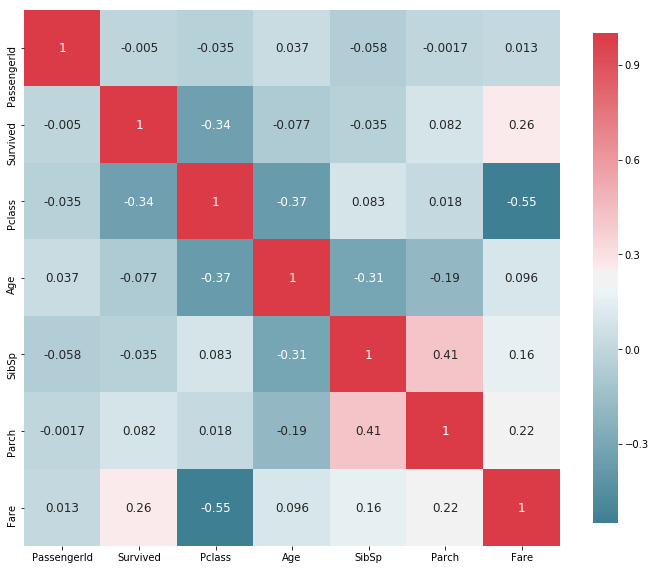

In [7]:
plot_correlation_map(full[:891])

Нет особо сильных корреляций с зависимой переменной, но видим умеренную корреляцию между Fare и Pclass. Пожалуй, выберем из них одну.

# Создание новых переменных: Title

Создадим переменную титул, посмотрим, как она связана с выживанием + используем ее для заполнения пропусков в возрасте.

In [8]:
full['Title'] = full['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
full['Title'] = full['Title'].apply(lambda x: x if x in 
                                    ['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Dr'] else 'Misc')
full['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Misc       18
Rev         8
Dr          8
Name: Title, dtype: int64

# Заполняем пропуски в Age и Embarked

Теперь используем титул для заполнения пропущенных значений. Опять работаем на всей выборке. Сначала посмотрим, где у нас есть пропущенные значения.

In [9]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


Обработаем пропущенные значения в переменных Age (по титулу), Fare (средним по классу), Embarked (модой).

In [10]:
full['Age'] = full.Age.fillna(full.groupby('Title')['Age'].transform('median'))

In [11]:
full['Fare'] = full.Fare.fillna(full.groupby('Pclass')['Fare'].transform('median'))

In [12]:
full['Embarked'] = full.Embarked.fillna(full['Embarked'].mode()[0])

In [13]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


Так же пропуски можно заполнять с помощью алгоритмов машинного обучения - например, попробуйте заполнить пропуски в возрасте с помощью алгоритма kNN, используя все остальные переменные, кроме Survived, чтобы рассчитать расстояние между точками (такой вопрос будет в контрольной).

# Создание новых переменных: размер семьи

Мы тоже уже это делали - складываем горизонтальных и вертикальных родственников, а также учитываем самого пассажира.

In [14]:
full['FamilySize'] = full['Parch'] + full['SibSp'] + 1

А теперь давайте попробуем понять, имеет ли смысл объединить категории.

In [15]:
full[:891].groupby('FamilySize')['Survived'].count()

FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: Survived, dtype: int64

C:\Users\rogov\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


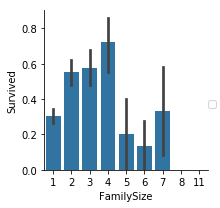

In [16]:
plot_categories(full[:891] , cat = 'FamilySize' , target = 'Survived' )

Мы видим, что в семьях размеров 2-4 процент выживших похож. И нет значительной разницы между семьями больше 5 человек. Давайте используем эту информацию для перекодирования переменных.

In [17]:
full['Family_Single'] = full[ 'FamilySize' ].apply(lambda s: 1 if s == 1 else 0)
full['Family_Small']  = full[ 'FamilySize' ].apply(lambda s: 1 if 2 <= s <= 4 else 0)
full['Family_Large']  = full[ 'FamilySize' ].apply(lambda s: 1 if 5 <= s else 0)

full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Family_Single,Family_Small,Family_Large
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,0,0


# Подготовка данных
Часть алгоритмов гораздо эффективней работает с переменными, которые закодированы как бинарные. Для этого можно применять метод OneHotEncoding, а можно сделать это методами pandas.

In [18]:
sex = pd.get_dummies(full.Sex , prefix='Sex')
sex.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [19]:
embarked = pd.get_dummies(full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [20]:
pclass = pd.get_dummies(full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [21]:
title = pd.get_dummies(full.Title , prefix='Title' )
title.head()

,Title_Dr,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0


# Объединяем датасет
Теперь все наши обработанные переменные объединим в один датасет, а потом разделим его обратно на нашу тренировочную и тестовую выборки.

In [22]:
full_X = pd.concat([full['Age'], embarked, title, pclass, full['Family_Single'], full['Family_Small'], full['Family_Large']] , axis=1)
full_X.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Pclass_1,Pclass_2,Pclass_3,Family_Single,Family_Small,Family_Large
0,22.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,38.0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2,26.0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0
3,35.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
4,35.0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0


Не берем оплату за проезд, потому что она коррелирует с классом и пол, потому что он "зашит" в титул.

In [119]:
from sklearn.model_selection import train_test_split

train_valid_X = full_X[:891]
train_valid_y = full[:891].Survived

train_X , test_X , train_y , test_y = train_test_split(train_valid_X , train_valid_y , 
                                                       test_size = 0.3, random_state=42)

print(full_X.shape , train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1309, 17) (623, 17) (623,) (268, 17) (268,)


# Пробуем разные модели

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

У нас есть функция, которая строит график для важности признаков на основе разбиения DesicionTreeClassifier

In [57]:
clf = DecisionTreeClassifier(max_leaf_nodes=5)
clf.fit(train_X, train_y)

feat_importance = clf.tree_.compute_feature_importances(normalize=False)
for c,f in sorted(zip(train_X.columns, feat_importance), key=lambda x:x[1]):
    print(c, f)

Age 0.0
Embarked_C 0.0
Embarked_Q 0.0
Embarked_S 0.0
Title_Dr 0.0
Title_Master 0.0
Title_Misc 0.0
Title_Miss 0.0
Title_Mrs 0.0
Pclass_1 0.0
Pclass_2 0.0
Family_Single 0.0
Family_Small 0.0
Title_Rev 0.010731483604677829
Family_Large 0.020278208431168485
Pclass_3 0.04032933622887357
Title_Mr 0.13453139877776416


[Text(353.125,386.645,'Title_Mr <= 0.5\ngini = 0.467\nsamples = 623\nvalue = [392, 231]\nclass = D'),
 Text(282.5,276.175,'Pclass_3 <= 0.5\ngini = 0.433\nsamples = 255\nvalue = [81, 174]\nclass = S'),
 Text(141.25,165.705,'Title_Rev <= 0.5\ngini = 0.18\nsamples = 130\nvalue = [13, 117]\nclass = S'),
 Text(70.625,55.235,'gini = 0.133\nsamples = 126\nvalue = [9, 117]\nclass = S'),
 Text(211.875,55.235,'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = D'),
 Text(423.75,165.705,'Family_Large <= 0.5\ngini = 0.496\nsamples = 125\nvalue = [68, 57]\nclass = D'),
 Text(353.125,55.235,'gini = 0.483\nsamples = 91\nvalue = [37, 54]\nclass = S'),
 Text(494.375,55.235,'gini = 0.161\nsamples = 34\nvalue = [31, 3]\nclass = D'),
 Text(423.75,276.175,'gini = 0.262\nsamples = 368\nvalue = [311, 57]\nclass = D')]

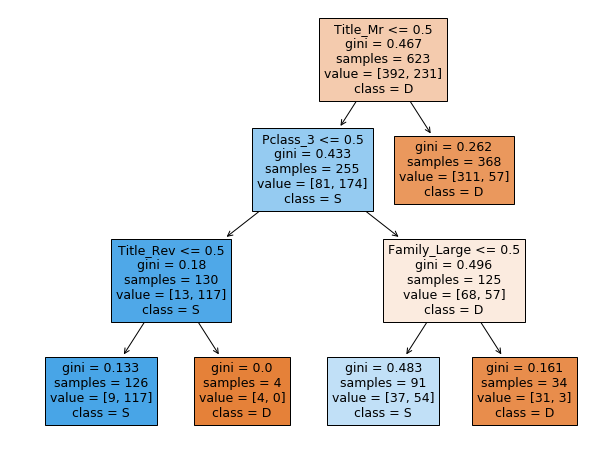

In [58]:
import sklearn.tree as tree

fn = train_X.columns
cn = ['D', 'S']
plt.figure(figsize=(10,8))
tree.plot_tree(clf, feature_names = fn, class_names=cn,filled = True)

$$N_t / N * (impurity - N_t_R / N_t * right_impurity  - N_t_L / N_t * left_impurity)$$

In [59]:
feature_importance_mr = 623/623 * (0.472 - 261/623 * 0.434 - 362/623 * 0.277)
feature_importance_mr

0.1292263242375602

А теперь как раз перейдем к построению разных моделей. Метрикой ошибки возьмем accuracy, как и в соревновании.

# Кросс-валидация, поиск параметров по сетке, случайный лес

In [60]:
from sklearn.model_selection import cross_validate

In [61]:
model = RandomForestClassifier(n_estimators=100)

Про кросс-валидацию можно подробнее прочитать здесь:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

Мы передаем функции cross_validate модель, тренировные x и y, указываем на сколько частей будем разбивать тренировочную выборку, метрику ошибки, и возвращать ли ошибку на тренировочной выборке.

In [62]:
scores = cross_validate(model, train_X, train_y, cv=3, scoring=('accuracy'))

In [63]:
scores

{'fit_time': array([0.14165759, 0.10374236, 0.10970187]),
 'score_time': array([0.01192904, 0.01197195, 0.01196837]),
 'test_score': array([0.8125    , 0.77403846, 0.81642512])}

Нас здесь интересует именно test_score - мы смотрим, что она не сильно скачет в зависимости от того, какую часть выборки мы отложили для теста.

In [64]:
np.mean(scores['test_score'])

0.8009878607704696

А вот так в среднем вела себя модель. Давайте попробуем написать функцию которая еще и будет делать подбор параметров по сетке внутри кросс-валидации.

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
parameters = {'n_estimators':[10, 50, 100, 200]}
model_cv = GridSearchCV(RandomForestClassifier(), parameters, 
                        cv=3, scoring=('accuracy'))

In [67]:
model_cv.fit(train_X, train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [68]:
model_cv.cv_results_

{'mean_fit_time': array([0.02093252, 0.06586337, 0.10654084, 0.22341673]),
 'std_fit_time': array([0.00664791, 0.01419667, 0.0051038 , 0.01714314]),
 'mean_score_time': array([0.00466363, 0.00728909, 0.01263189, 0.02225788]),
 'std_score_time': array([0.00047945, 0.00046164, 0.0005122 , 0.00124519]),
 'param_n_estimators': masked_array(data=[10, 50, 100, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 200}],
 'split0_test_score': array([0.79807692, 0.82692308, 0.82211538, 0.81730769]),
 'split1_test_score': array([0.75480769, 0.76442308, 0.76923077, 0.77884615]),
 'split2_test_score': array([0.78743961, 0.80193237, 0.81642512, 0.8115942 ]),
 'mean_test_score': array([0.78010808, 0.79775951, 0.80259042, 0.80258268]),
 'std_test_score': array([0.0184096 , 0.02568556, 0.02370295, 0.01694556]),
 'rank_test_score': array([4, 3, 1, 2

Здесь теперь анализируем иначе. 
Так `'split0_test_score': array([0.73076923, 0.75      , 0.74038462, 0.74038462])` это значения каждого из параметров n_estimators по первой разбивке.
Но не пугайтесь, лучшую модель выбрать несложно - нужно посмотреть на средний score или на ранги (rank_test_score). По рангу понимаем, какая модель справилась лучше (заняла первое место).

In [70]:
model_cv.cv_results_['rank_test_score']

array([4, 3, 1, 2])

Давайте посмотрим теперь внимательно на среднее значение ошибки по тестам. То же самое. Точность выше всего на моделе с первым местом.

In [71]:
model_cv.cv_results_['mean_test_score']

array([0.78010808, 0.79775951, 0.80259042, 0.80258268])

In [72]:
model_cv.best_score_ # выводим лучшую точность

0.8025904248730336

In [73]:
model_cv.best_params_ # выводим лучшие параметры

{'n_estimators': 100}

In [75]:
model_cv.best_estimator_ # выводим лучший алгоритм с лучшими параметрами

RandomForestClassifier()

Давайте теперь эту модель проверим на нашей отложенной тестовой выборке.

In [76]:
best_model = model_cv.best_estimator_ 

In [77]:
best_model.fit(train_X, train_y)

RandomForestClassifier()

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(best_model.predict(test_X), test_y)

0.7985074626865671

Запомнили значение. Чуть позже выберем нашего победителя и отправим его на kaggle.
Напоминаю, что лучшее наше предсказание по baseline модели было 0.77 (все женщины и дети выжили).

# KNN
Давайте теперь попробуем KNN. Тоже с поиском параметров по сетке.

In [79]:
parameters = {'n_neighbors':[3, 5, 10, 15]}
model_cv = GridSearchCV(KNeighborsClassifier(), parameters, 
                        cv=3, scoring=('accuracy'))

In [80]:
model_cv.fit(train_X, train_y)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 10, 15]}, scoring='accuracy')

In [81]:
model_cv.cv_results_

{'mean_fit_time': array([0.00731095, 0.00564003, 0.00567675, 0.00663614]),
 'std_fit_time': array([0.00401746, 0.00049113, 0.0012602 , 0.00233578]),
 'mean_score_time': array([0.003992  , 0.00764791, 0.00597072, 0.00466752]),
 'std_score_time': array([1.36730278e-06, 2.48886263e-03, 1.67131254e-05, 1.24802145e-03]),
 'param_n_neighbors': masked_array(data=[3, 5, 10, 15],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15}],
 'split0_test_score': array([0.77403846, 0.76923077, 0.75961538, 0.73076923]),
 'split1_test_score': array([0.74519231, 0.75961538, 0.71153846, 0.67788462]),
 'split2_test_score': array([0.74879227, 0.76811594, 0.69565217, 0.70531401]),
 'mean_test_score': array([0.75600768, 0.76565403, 0.72226867, 0.70465595]),
 'std_test_score': array([0.01283411, 0.00429416, 0.02719284, 0.02159507]),
 'rank_test_score': array([2, 1, 3

Тут уже на кросс-валидации видим, что качество ниже RandomForest, но выберем лучшую модель и протестируем ее.

In [82]:
print(model_cv.best_score_)
print(model_cv.best_params_)
print(model_cv.best_estimator_)

0.7656540319583797
{'n_neighbors': 5}
KNeighborsClassifier()


In [83]:
best_model = model_cv.best_estimator_
best_model.fit(train_X, train_y)
accuracy_score(best_model.predict(test_X), test_y)

0.7649253731343284

Модель справилась хуже. Идем эксперементировать дальше.

# Логистическая регрессия
Попробуем, наверняка, знакомую вам логистическую регрессию. Она как раз должна здорово работать с бинарным таргетом. Тут подбирать ничего не будем, проверим на кросс-валидации.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [120]:
cv = cross_validate(LogisticRegression(max_iter=1000), train_X, train_y, 
                        cv=3, scoring=('accuracy'))

In [121]:
cv

{'fit_time': array([0.06981444, 0.06781745, 0.05385518]),
 'score_time': array([0.00399017, 0.00199533, 0.00199652]),
 'test_score': array([0.83173077, 0.79326923, 0.83574879])}

Неплохой результат. Попробуем на отложенной выборке.

In [123]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(train_X, train_y)
accuracy_score(best_model.predict(test_X), test_y)

0.8283582089552238

# Градиентный бустинг
Последний классификатор, на который сегодня посмотрим - градиентный бустинг. Как и случайный лес - это ансанбль (делает предсказание на основании многих алгоритмов). Как случайный лес, использует решающие деревья. Главное отличие в том, что случайный лес строит много-много деревеьев, а потом выбирает предсказание из них за счет голосования или усредняя непрерывное предсказание. Градиентный бустинг строит по одному дереву, для каждого из них считает ошибку и каждым последующим деревом пытается минимизировать ошибку предыдущего. Давайте посмотрим, как он справится здесь.

https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained

In [124]:
cv = cross_validate(GradientBoostingClassifier(), train_X, train_y, cv=3, scoring=('accuracy'))
cv

{'fit_time': array([0.10970855, 0.08377314, 0.08477283]),
 'score_time': array([0.00398779, 0.00299525, 0.00305128]),
 'test_score': array([0.86057692, 0.81730769, 0.80193237])}

In [125]:
best_model = GradientBoostingClassifier()
best_model.fit(train_X, train_y)
accuracy_score(best_model.predict(test_X), test_y)

0.8097014925373134

# Kaggle Submission

Все равно хуже, чем логистическая регрессия. Давайте сгенерируем для нее предсказание и проверим его на kaggle.

In [126]:
model = LogisticRegression(max_iter=1000)
test_X = full_X[891:]
model.fit(train_valid_X, train_valid_y)
pred = model.predict(test_X)
test = pd.DataFrame({'PassengerId': full[891:].PassengerId , 'Survived': pred})
test['Survived'] = test['Survived'].apply(lambda x: int(x))
print(test.shape)
test.head()


(418, 2)


,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1


In [127]:
test.to_csv('titanic_pred_lr.csv' , index = False )

На тестовой выборке kaggle получили 78% - хуже чем для нашего эксперимента, но лучше baseline (небольшая, но победа). Если вы хотите дальше развиваться в машинном обучении - kaggle это отличное место, чтобы обрабатывать полученные навыки.